In [1]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization

In [2]:
print("Num GPUs: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs:  1


In [ ]:
# Encontra diretorio atual
atual_dir = os.getcwd()

# Acessa arquivo pkl das noticias
parent_dir = os.path.split(atual_dir)

parent_dir = os.path.split(parent_dir[0])

parent_dir = os.path.split(parent_dir[0])

caminho_pkl = os.path.join(parent_dir[0], "Pre-processamento\\df_pre_processado.pkl")

# Carrega dataframe salvo em formato pickle
df = pd.read_pickle(caminho_pkl)

df.head()

,Texto,Categoria,label
0,"[poder, decidir, expulsar, deputado, federal, ...",Real,1
1,"[bolsonaro, liberal, completo, presidente, psl...",Real,1
2,"[ministro, stf, liberar, Andrea, Neves, prisao...",Real,1
3,"[apesar, abundancia, crescer, preocupacao, pre...",Real,1
4,"[harvard, mit, levarao, dilma, moro, suplicy, ...",Real,1


In [4]:
# Converte a coluna 'Texto' do DataFrame em uma lista e armazena na variável texts. O mesmo com as labels
texts = df['Texto'].tolist()
labels = df['label'].tolist()  

In [5]:
# Tokenização
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# word_index é um dicionário onde as chaves são as palavras e os valores são os índices dessas palavras.
# Esse índice é útil para várias tarefas de NLP, como a criação de embeddings de palavras ou a preparação de dados para modelos de deep learning.
word_index = tokenizer.word_index

In [6]:
# Salva o tokenizador em um arquivo (precisamos dele mais tarde, quando realizarmos as inferências)
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [ ]:
# Carrega o valor de max_length de um arquivo pickle
caminho_max_length = os.path.join(parent_dir[0],"Pre-processamento\\max_length.pkl")
with open(caminho_max_length, 'rb') as f:
    max_length = pickle.load(f)

print("max_length: ", max_length)

max_length:  512


In [8]:
# Carrega os embeddings do GLoVe
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [9]:
# Prepara a matriz de embedding
embedding_dim = 100  # o tamanho do GLoVe embeddings (100)
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [10]:
# Converte rótulos para inteiros
num_classes = df['label'].nunique()
labels = df['label'].values

In [11]:
# Realiza o preenchimento das sequências com base no novo 'max_length'
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [12]:
# Divide os dados em um conjunto de treino (70%) e um conjunto temporário (30%)
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3, stratify=labels, random_state=15)

# Divide o conjunto temporário em conjuntos de validação (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=15)

In [ ]:
# Cria modelo BiLSTM 
model = Sequential()

# Camada de embedding para representação de palavras
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, 
                    weights=[embedding_matrix], trainable=False))

# Normalização de lote
model.add(BatchNormalization())

# Adiciona a primeira camada BiLSTM com retorno de sequências
model.add(Bidirectional(LSTM(units=128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))))
model.add(Dropout(0.5))

# Adiciona a segunda camada BiLSTM com retorno de sequências
model.add(Bidirectional(LSTM(units=128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))))
model.add(Dropout(0.5))

# Adiciona a terceira camada BiLSTM com retorno de sequências
model.add(Bidirectional(LSTM(units=64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))))
model.add(Dropout(0.5))

# Adiciona a última camada BiLSTM sem retorno de sequências
model.add(Bidirectional(LSTM(units=32, kernel_regularizer=tf.keras.regularizers.l2(0.001))))
model.add(Dropout(0.5))

# Adiciona camada densa com ativação sigmoide
model.add(Dense(1, activation='sigmoid'))

# Configura parada antecipada baseada na perda de validação
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Compila o modelo com função de perda, otimizador e métricas
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'Precision', 'Recall'])

# Treina o modelo com dados de treinamento e validação, usando parada antecipada como callback e exibindo o progresso
history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)


Epoch 1/40
244/244 [==============================] - 120s 430ms/step - loss: 0.9856 - accuracy: 0.7621 - precision: 0.7923 - recall: 0.6994 - val_loss: 0.7130 - val_accuracy: 0.8011 - val_precision: 0.8468 - val_recall: 0.7267
Epoch 2/40
244/244 [==============================] - 105s 429ms/step - loss: 0.6277 - accuracy: 0.8284 - precision: 0.8598 - recall: 0.7776 - val_loss: 0.6420 - val_accuracy: 0.8041 - val_precision: 0.8606 - val_recall: 0.7176
Epoch 3/40
244/244 [==============================] - 108s 441ms/step - loss: 0.5579 - accuracy: 0.8398 - precision: 0.8446 - recall: 0.8260 - val_loss: 0.4755 - val_accuracy: 0.8741 - val_precision: 0.8717 - val_recall: 0.8722
Epoch 4/40
244/244 [==============================] - 108s 442ms/step - loss: 0.4649 - accuracy: 0.8770 - precision: 0.8766 - recall: 0.8727 - val_loss: 0.4468 - val_accuracy: 0.8729 - val_precision: 0.8496 - val_recall: 0.9008
Epoch 5/40
244/244 [==============================] - 110s 451ms/step - loss: 0.4102 - a

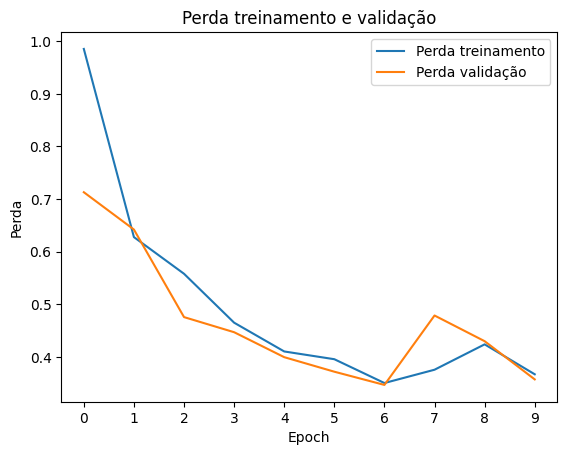

In [14]:
# Plota a perda (loss) e a perda de validação (val_loss) durante o treinamento
plt.plot(history.history['loss'], label='Perda treinamento')
plt.plot(history.history['val_loss'], label='Perda validação')
plt.title('Perda treinamento e validação')
plt.xlabel('Epoch')
plt.ylabel('Perda')
plt.xticks(range(len(history.history['loss'])))
plt.legend()
plt.show()

In [15]:
# Salva os arquivos
model.save('modelo_BiLSTM_glove6b100d.h5')
np.save("X_test_BiLSTM_glove6b100d.npy", X_test)
np.save("y_test_BiLSTM_glove6b100d.npy", y_test)